In [42]:
import numpy as np
import matplotlib.pyplot as plt
from helper_methods import get_train_val, create_dataset, show_images

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from torch.utils.data import TensorDataset, DataLoader

In [18]:
df_train, df_val = get_train_val(filepath='datasets/annotations/trainval.txt', val_size=0.2)
X_train, Y_train = create_dataset(df_train, base_path='datasets/images/')
X_val, Y_val = create_dataset(df_val, base_path='datasets/images/')

### Defome the base class for Image Classification

In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):

        images, labels = batch 
        out = self(images)
        with torch.no_grad():
            loss = F.cross_entropy(out, labels)   
            acc = accuracy(out, labels)           
        
        return {'val_loss': loss.detach(), 'val_acc': acc}

In [21]:
class DogsCatsCnnModelResNet18(ImageClassificationBase):
    def __init__(self):
        
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 2)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [40]:
@torch.no_grad()
def evaluate(model: ImageClassificationBase, X_val, Y_val):

    model.eval()
    batch = [X_val, Y_val]
    outputs = model.validation_step(batch)
    
    return outputs

def fit(model: ImageClassificationBase, epochs, lr, X_train, Y_train, X_val, Y_val, batch_size=32, opt_func=torch.optim.SGD):

    history = []
    optimizer = opt_func(model.parameters(), lr)

    # Create TensorDataset and DataLoader for training data
    train_dataset = TensorDataset(X_train, Y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    for epoch in range(epochs):
        print(f"Epoch: {epoch}")
                
        # Training Phase 
        model.train()
        train_losses = []
        for i, batch in enumerate(train_loader):
            print(f"  - Batch {i}/{int(len(X_train) / batch_size)}")
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, X_val, Y_val)
        print(f"Epoch {epoch}, result: {result}")
        history.append(result)
        
    return history

In [23]:
model_resnet_18 = DogsCatsCnnModelResNet18()

#### Performance on validation set with initial set of params

In [24]:
print(evaluate(model_resnet_18, X_val, Y_val))

{'val_loss': tensor(0.6810), 'val_acc': tensor(0.6522)}


#### Try training for X epochs

In [25]:
num_epochs = 3
opt_func = torch.optim.Adam
batch_size = 256
lr = 0.001

In [43]:
history0 = fit(model_resnet_18, num_epochs, lr, X_train, Y_train, X_val, Y_val, batch_size, opt_func)

Epoch: 0
  - Batch 0/11
  - Batch 1/11
  - Batch 2/11
  - Batch 3/11
  - Batch 4/11
  - Batch 5/11
  - Batch 6/11
  - Batch 7/11
  - Batch 8/11
  - Batch 9/11
  - Batch 10/11
  - Batch 11/11
Epoch 0, result: {'val_loss': tensor(0.3816), 'val_acc': tensor(0.9307)}
Epoch: 1
  - Batch 0/11
  - Batch 1/11
  - Batch 2/11
  - Batch 3/11
  - Batch 4/11
  - Batch 5/11
  - Batch 6/11
  - Batch 7/11
  - Batch 8/11
  - Batch 9/11
  - Batch 10/11
  - Batch 11/11
Epoch 1, result: {'val_loss': tensor(0.3973), 'val_acc': tensor(0.9130)}
Epoch: 2
  - Batch 0/11
  - Batch 1/11
  - Batch 2/11
  - Batch 3/11
  - Batch 4/11
  - Batch 5/11
  - Batch 6/11
  - Batch 7/11
  - Batch 8/11
  - Batch 9/11
  - Batch 10/11
  - Batch 11/11
Epoch 2, result: {'val_loss': tensor(0.4127), 'val_acc': tensor(0.8981)}


In [44]:
history0

[{'val_loss': tensor(0.3816), 'val_acc': tensor(0.9307)},
 {'val_loss': tensor(0.3973), 'val_acc': tensor(0.9130)},
 {'val_loss': tensor(0.4127), 'val_acc': tensor(0.8981)}]

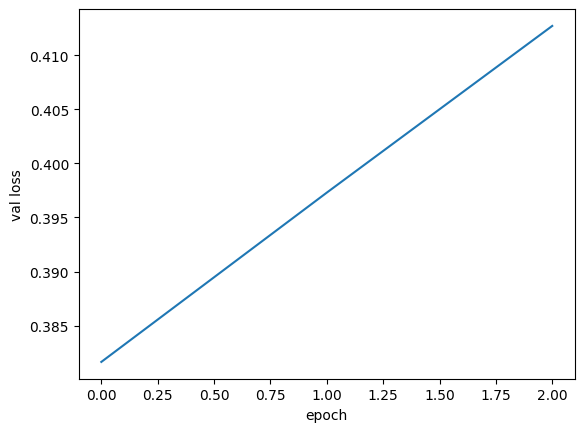

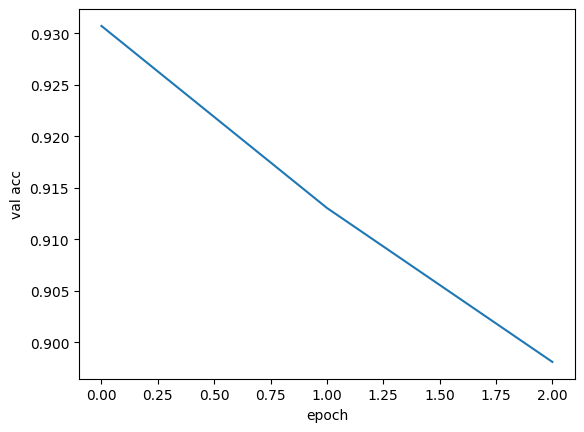

In [46]:
def plot_results(history):
    val_loss = [d['val_loss'] for d in history]
    val_acc = [d['val_acc'] for d in history]
    plt.plot(val_loss)
    plt.xlabel('epoch')
    plt.ylabel('val loss')
    plt.show()
    plt.plot(val_acc)
    plt.xlabel('epoch')
    plt.ylabel('val acc')
    plt.show()

plot_results(history0)